# Heuristic Algorithms for Automated Data Extraction

In [2]:
%load_ext autoreload
%autoreload 2

import cv2
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import IPython
import scipy.ndimage as ndimage
from sklearn import datasets, linear_model
from PIL import Image
import pytesseract as tes

from fairplay.legacy import ocr_tools, find_axes
from fairplay.legacy.thresholding import adaptive_thresh
from fairplay.img.img_proc import rect_mask_grayscale

print('All packages loaded')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
All packages loaded


In [3]:
examples_dir = Path('../data/real_images/')
temp_dir = Path('../data/temp/')

# Load

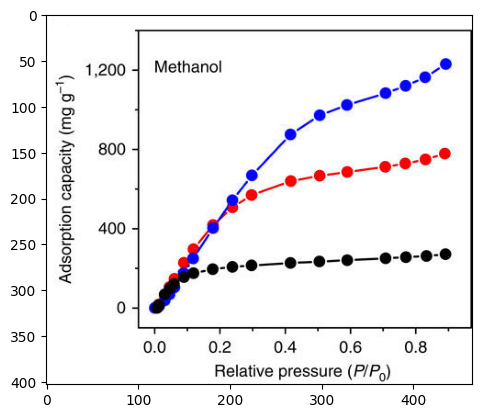

In [4]:
example = examples_dir.joinpath('example102.jpg').as_posix()

img = cv2.imread(example)
m,n,p=img.shape

plt.figure()
implot = plt.imshow(img)

# Binarize

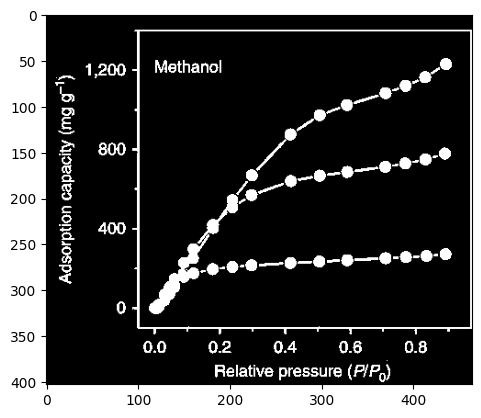

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# bw4 = adaptive_thresh(gray)
nbw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 5)
# nbw = (255-bw4)

plt.figure()
implot = plt.imshow(nbw, cmap='gray')

# Finding Axes

Now we are going to engineer an axis feature score, for example, the x-axis:

[cos^2, fractional length, fractional y-coord (or x coord for y axis)]

"How horizontal is this line segment?"
"How long is it relative to the image size?"
"Where is it in the image?"

In [6]:
linesP = cv2.HoughLinesP(nbw, 1, np.pi/2, 2, minLineLength=nbw.shape[1]/10, maxLineGap=3)
print('Hough Transform complete')

# print(linesP)
xax = find_axes.get_xaxis(np.reshape(linesP, (-1,4)), nbw)
print('x axis')
print(xax)
yax = find_axes.get_yaxis(np.reshape(linesP, (-1,4)), nbw)
print('y axis')
print(yax)

Hough Transform complete
x axis
[101 341 462 341]
y axis
[101 340 101  19]


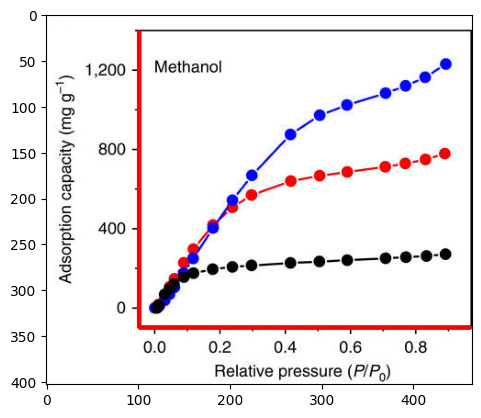

In [7]:
imlabel = img.copy();
cv2.line(imlabel, (xax[0], xax[1]), (xax[2], xax[3]), (255, 0, 0), 4)
cv2.line(imlabel, (yax[0], yax[1]), (yax[2], yax[3]), (255, 0, 0), 4)

plt.figure()
implot = plt.imshow(imlabel)
implot.set_cmap('gray')

## Get axis label text

Define the "ROI" - the area above and to the right of the x- and y- axes respectively. Then use this to find the "outer ROI" - the area below the x-axis and to the left of the y-axis.

In [8]:
roi_corners = np.array([
    min(yax[0], yax[2]),
    min(yax[1], yax[3]),
    max(xax[0], xax[2]),
    max(xax[1], xax[3])
])
print("ROI (x1, y1, x2, y2) in numpy array coords (inverse Y)\n", roi_corners)

ROI (x1, y1, x2, y2) in numpy array coords (inverse Y)
 [101  19 462 341]


## This must be some kind of experimental one-shot RANSAC section

In [ ]:
# Copy the image to a new file for OCR
axis_text_img = img #rect_mask_grayscale(img, roi_corners)
axis_text_path = temp_dir.joinpath('axis_text.png').as_posix()
cv2.imwrite(axis_text_path, axis_text_img)

# Run OCR and return the cleaned DataFrame of results ("text" column)
axis_text_ocr_res = ocr_tools.get_ocr_df(axis_text_path)
axis_text_ocr_res = axis_text_ocr_res[axis_text_ocr_res['top'] >= roi_corners[3]]
axis_text_ocr_res['text'] = axis_text_ocr_res['text'].replace(['O', 'o'], '0')
axis_text_ocr_res['num'] = axis_text_ocr_res['text'].apply(pd.to_numeric, errors='coerce')

# Get just the results that are numeric text
axis_text_nums = axis_text_ocr_res[axis_text_ocr_res['num'].notnull()].copy()
axis_text_nums

In [ ]:
regry = linear_model.RANSACRegressor(residual_threshold=0.1, min_samples=3)
regry.fit(
    axis_text_nums['y_mid'].values.reshape(-1,1),  # y_mid is the midpoints of the bounding box for each detected text object
    axis_text_nums['num'].values.reshape(-1,1)
)

# The coefficients
print('Coefficients: \n', regry.estimator_.coef_)
print('Intercept: \n', regry.estimator_.intercept_)
print('Inliers: \n', regry.inlier_mask_)

## Locating Ticks and Tick Labels

It's actually easier to start by finding the labels - in fact, in many cases it's not necessary to even find the ticks at all.

OCR is difficult. Tesseract is the best open source library for it, but it's not a panacea. We can help it by first isolating the region from which we'd like to extract text.

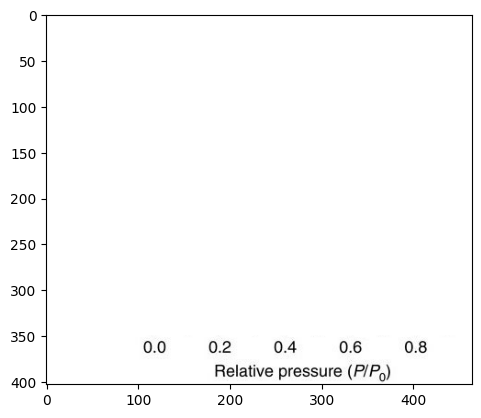

In [9]:
# Find where the x-ticks stop and crop the text image to be below that
below_xax_bw = np.zeros([m, n]).astype('uint8')
below_xax_bw[xax[1]:, :] = nbw[xax[1]:, :]
row_sums = below_xax_bw.sum(axis=1)
row_sums[0: xax[1]] = 1000
row_sums_list = row_sums.tolist()
text_crop_ind = row_sums_list.index(0)
text_crop_ind

xTextImg = np.ones([m, n, p]).astype('uint8') * 255
xTextImg[text_crop_ind + 1:, :, :] = img[text_crop_ind + 1:, :, :]
xTextPath = temp_dir.joinpath('xtext.png').as_posix()
cv2.imwrite(xTextPath, xTextImg)

plt.figure()
implot = plt.imshow(xTextImg)

### Here, we perform OCR, then pick out only the numbers.

In [10]:
xt_ocr_df = ocr_tools.get_ocr_df(xTextPath)
xt_ocr_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,right,bottom,x_mid,y_mid
4,5,1,1,1,1,1,97,352,33,26,96,0.0,130,378,113,365
5,5,1,1,1,1,2,178,356,22,13,94,0.2,200,369,189,362
6,5,1,1,1,1,3,249,352,22,26,95,0.4,271,378,260,365
7,5,1,1,1,1,4,320,352,22,26,95,0.6,342,378,331,365
8,5,1,1,1,1,5,391,356,24,13,95,0.8,415,369,403,362
10,5,1,1,1,2,1,185,382,62,13,96,Relative,247,395,216,388
11,5,1,1,1,2,2,254,385,68,14,92,pressure,322,399,288,392
12,5,1,1,1,2,3,329,381,46,19,3,(P/P)),375,400,352,391


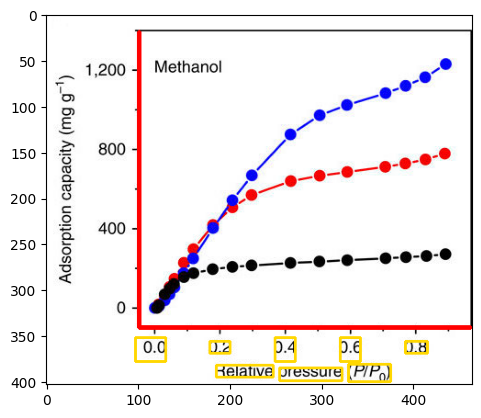

In [11]:
plt.figure()
for ii, row in xt_ocr_df.iterrows():
    cv2.rectangle(
        imlabel,
        (row['left'], row['top']),
        (row['left'] + row['width'], row['top'] + row['height']),
        (255,215,0),
        thickness=2,
        lineType=8,
        shift=0
    )
implot = plt.imshow(imlabel)

### Now, we use another Hough transform to find ticks, and match them with their nearest label.

In [12]:
xt_array = find_axes.get_xticks(nbw, xax, tickMargin=11, minTickLen=4, maxGap=0)
xt_list = xt_array.tolist()
xt_list

[[100, 342, 100, 330],
 [101, 342, 101, 330],
 [117, 348, 117, 341],
 [118, 348, 118, 341],
 [119, 347, 119, 341],
 [153, 345, 153, 341],
 [154, 345, 154, 341],
 [188, 348, 188, 341],
 [189, 348, 189, 341],
 [190, 347, 190, 341],
 [224, 345, 224, 341],
 [225, 345, 225, 341],
 [259, 347, 259, 341],
 [260, 348, 260, 341],
 [261, 348, 261, 341],
 [295, 345, 295, 341],
 [296, 345, 296, 341],
 [331, 348, 331, 341],
 [332, 348, 332, 341],
 [366, 345, 366, 341],
 [367, 345, 367, 341],
 [402, 348, 402, 341],
 [403, 348, 403, 341],
 [437, 345, 437, 341],
 [438, 345, 438, 341],
 [439, 345, 439, 341],
 [462, 342, 462, 330]]

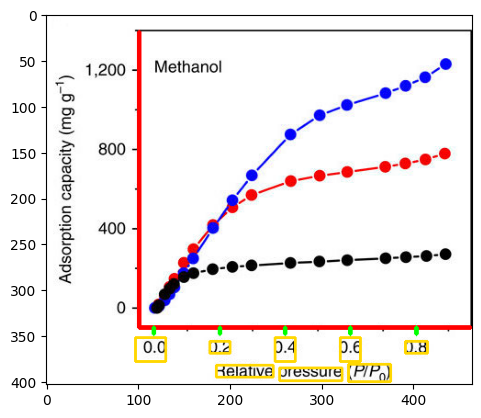

In [13]:
# Narrow OCR results to just numbers
xt_ocr_num_df = xt_ocr_df.copy()
xt_ocr_num_df['text'] = xt_ocr_num_df['text'].apply(pd.to_numeric, errors="coerce")
xt_ocr_num_df = xt_ocr_num_df[xt_ocr_num_df['text'].notnull()]

xt_match = find_axes.match_xticks(xt_ocr_num_df, xt_list)
xt_pts = [xt_list[i] for i in xt_match]

plt.figure()
for x1,y1,x2,y2 in xt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),4)
implot = plt.imshow(imlabel)

## Convert x-axis from pixel space to data space with regression

In [14]:
xt_pts_array = np.array(xt_pts)
# xt_pts_array[:,0].reshape(-1,1)
print('X Axis in pixels')
print(xt_pts_array[:,0].reshape(-1,1))

# xt_labels[:,0].reshape(-1,1)
xt_labels = xt_ocr_num_df['text'].values
print('X Axis in Data')
print(xt_labels.reshape(-1,1))

regrx = linear_model.LinearRegression(fit_intercept=True)
regrx.fit(xt_pts_array[:,0].reshape(-1,1), xt_labels.reshape(-1,1))

# The coefficients
print('Coefficients: \n', regrx.coef_)
print('Intercept: \n', regrx.intercept_)

X Axis in pixels
[[117]
 [189]
 [260]
 [331]
 [403]]
X Axis in Data
[[0. ]
 [0.2]
 [0.4]
 [0.6]
 [0.8]]
Coefficients: 
 [[0.0028011]]
Intercept: 
 [-0.3282856]


## For Y-Ticks, the rotated text breaks pytesseract OCR

To solve this, we isolate the text, rotate it, remove the axis label, rotate back, then perform OCR.

In [ ]:
yax

In [ ]:
# Find the first "empty" column of pixels to the left of the y-axis and crop the text image to be left of that
left_yax_bw = np.zeros([m, n]).astype('uint8')
left_yax_bw[:yax[0], :] = nbw[:yax[0], :]
col_sums = left_yax_bw.sum(axis=0)
col_sums[yax[0]:] = 1000
col_zeros = np.where(col_sums == 0)[0]
y_crop_ind = col_zeros[-1]
yTextImg = np.ones([m, n, p]).astype('uint8') * 255
yTextImg[:, 0:y_crop_ind-1, :] = img[:, 0:y_crop_ind-1, :]
yTextPath = temp_dir.joinpath('ytext.png').as_posix()
cv2.imwrite(yTextPath, yTextImg)

fig, axes = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)
plt.sca(axes[0])
yTextPlot = plt.imshow(yTextImg)
yTextPlot.set_cmap('gray')

yTextRot = ndimage.interpolation.rotate(yTextImg, -90)
yTextRotPath = temp_dir.joinpath('yTextRot.png').as_posix()
cv2.imwrite(yTextRotPath, yTextRot)
plt.sca(axes[1])
yTextRotPlot = plt.imshow(yTextRot)
yTextRotPlot.set_cmap('gray')

In [ ]:
yRotOcr = ocr_tools.get_ocr_df(yTextRotPath)
yRotOcr

In [ ]:
tes.image_to_string()

In [ ]:
yRotOcr = tes.image_to_string(Image.open(yTextRotPath))
print('Y-Axis OCR complete')
yrot_words = ocr_tools.clean_ocr_results(yRotOcr,charspace=15,neg_charspace=-3)
word_length = [len(i[0]) for i in yrot_words]
longest_word = np.array(word_length).argmax()
lwbox = yrot_words[longest_word]
x1 = lwbox[1]-1
y1 = lwbox[2]-1
x2 = lwbox[3]+1
y2 = lwbox[4]+1
y1 = n-y1
y2 = n-y2
yTextRot[y2:y1+1,x1:x2+1,:] = np.ones([y1-y2+1,x2-x1+1,3]).astype('uint8')*255
yText_Clean = ndimage.interpolation.rotate(yTextRot, 90)

plt.figure()
implot = plt.imshow(yText_Clean)

### Conventional OCR

In [ ]:
cv2.imwrite('temp/ytextclean.png',yText_Clean)
yocr = tes.image_to_string(Image.open('temp/ytextclean.png'),boxes=True)
yl_ocr = ocr_tools.clean_ocr_results(yocr)
yt_numbers = [w for w in yl_ocr if is_number(w[0])]
for w in yt_numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
yt_label_array = np.array(yt_numbers)

%matplotlib notebook
plt.figure()
for w in yt_numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)
implot = plt.imshow(imlabel)

In [ ]:
yt_dirty = find_axes.get_yticks(nbw,yax,tickMargin=11,minTickLen=0,maxGap=2)
yt_list=yt_dirty.tolist()
yt_match = find_axes.match_xticks(yt_numbers,yt_list)
yt_pts = [yt_list[i] for i in yt_match]
yt_pts

%matplotlib notebook
plt.figure()
for x1,y1,x2,y2 in yt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)
implot = plt.imshow(imlabel)

In [ ]:
yt_pts_array = np.array(yt_pts)
print('y axis pixels')
print(yt_pts_array[:,1].reshape(-1,1))
print('y axis data')
print(yt_label_array[:,0].reshape(-1,1))

regry = linear_model.LinearRegression(fit_intercept=True)
regry.fit(yt_pts_array[:,1].reshape(-1,1), yt_label_array[:,0].reshape(-1,1))

# The coefficients
print('Coefficients: \n', regry.coef_)
print('Intercept: \n', regry.intercept_)

## Finally, extract the data.

In more advanced approaches, a trained CNN can be used to identify data markers. Here, we can achieve similar performance with binary erosion. Multiple series with different colors can be dealt with through clustering.

In [ ]:
num_series = 4

from color_series_scrape import color_series_scrape
pix_pts, ROI = color_series_scrape(example, [[xax[0],xax[2]]],[[yax[3],yax[1]]], n_colors=num_series)
print('Done clustering')

import skimage.filters
from cluster_data import cluster_colorspace_km, cluster_colorspace_ms, return_series
im_recon, im_label = cluster_colorspace_km(ROI[0], num_series)
labels_as_ims = return_series(im_label)

In [ ]:
%matplotlib notebook
plt.figure()
plt.imshow(labels_as_ims[2])

In [ ]:
imlabel4 = imlabel.copy()
pp_list = []
for series in pix_pts[0]:
    s_list = []
    for tup in series:
        x = int(round(tup[1]))+xax[0]
        y = int(round(tup[0]))+yax[3]
        s_list.append([x,y])
    pp_list.append(s_list)

pp_list

for series in pp_list:
    for pt in series:
        cv2.circle(imlabel4,(pt[0],pt[1]), 3, (255,240,10), -1)
        
%matplotlib notebook
lastplot = plt.imshow(imlabel4)

## ... and convert the pixel values to the units of the axes

In [ ]:
data_list = []
for series in pp_list:
    ser_list = []
    for pt in series:
        xdata = pt[0]*regrx.coef_+regrx.intercept_
        ydata = pt[1]*regry.coef_+regry.intercept_
        ser_list.append([xdata[0,0],ydata[0,0]])
    data_list.append(ser_list[::-1])

[[format(j[0],'.3f'),format(j[1],'.3f')] for j in data_list[0]]